In [1]:
%%writefile architecture.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # 1. ENCODER
        # Input: FashionMNIST images are 28x28 = 784 pixels
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20) # Mean (mu)
        self.fc22 = nn.Linear(400, 20) # Log Variance (logvar)

        # 2. DECODER
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

Writing architecture.py


In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from architecture import VAE
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

Training on: cuda


In [13]:
#loading vae model
vae_model = VAE().to(device)
optimiser = optim.Adam(vae_model.parameters(), lr=1e-3)

#preparing data transformation
transformed = transforms.ToTensor()

#loading training dataset
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transformed)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

#loading validation dataset
val_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transformed)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

#loss function combining reconstruction and kl divergence
def vae_loss(reconstructed, original, mu, logvar):
  reconstruction_loss = F.mse_loss(reconstructed, original.view(-1, 784), reduction='sum')
  kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return reconstruction_loss + kl_divergence

#tracking losses
train_losses = []
val_losses = []

num_epochs = 10

#training loop
for epoch in range(num_epochs):

  #training phase
  vae_model.train()
  training_loss = 0

  for inputs, _ in train_loader:
    inputs = inputs.to(device)

    optimiser.zero_grad()
    reconstructed, mu, logvar = vae_model(inputs)
    loss = vae_loss(reconstructed, inputs, mu, logvar)
    loss.backward()
    optimiser.step()

    training_loss += loss.item()

  train_loss = training_loss / len(train_dataset)
  train_losses.append(train_loss)

  #validation phase
  vae_model.eval()
  validation_loss = 0

  with torch.no_grad():
    for inputs, _ in val_loader:
      inputs = inputs.to(device)
      reconstructed, mu, logvar = vae_model(inputs)
      validation_loss += vae_loss(reconstructed, inputs, mu, logvar).item()

  val_loss = validation_loss / len(val_dataset)
  val_losses.append(val_loss)

  print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")

print("\nTraining complete")
print(f"Train losses: {train_losses}")
print(f"Val losses: {val_losses}")

Epoch 1/10 - Train Loss: 39.53, Val Loss: 31.08
Epoch 2/10 - Train Loss: 29.30, Val Loss: 28.08
Epoch 3/10 - Train Loss: 27.55, Val Loss: 27.02
Epoch 4/10 - Train Loss: 26.73, Val Loss: 26.52
Epoch 5/10 - Train Loss: 26.30, Val Loss: 26.12
Epoch 6/10 - Train Loss: 25.91, Val Loss: 25.75
Epoch 7/10 - Train Loss: 25.65, Val Loss: 25.49
Epoch 8/10 - Train Loss: 25.47, Val Loss: 25.41
Epoch 9/10 - Train Loss: 25.26, Val Loss: 25.16
Epoch 10/10 - Train Loss: 25.12, Val Loss: 25.11

Training complete
Train losses: [39.52890096435547, 29.299173185221353, 27.5458774210612, 26.72913819173177, 26.29624248453776, 25.907553763834635, 25.646725634765627, 25.466036283365884, 25.261952608235678, 25.119490299479168]
Val losses: [31.08054040527344, 28.075687768554687, 27.02499789428711, 26.515521405029297, 26.119155590820313, 25.749846447753907, 25.49382182006836, 25.409400579833985, 25.159083728027344, 25.10675426635742]


Part 2

Generating reconstructions...


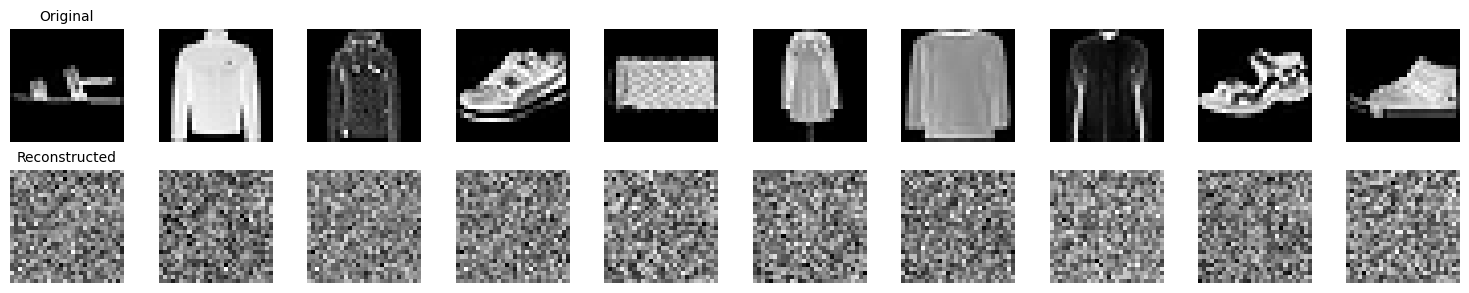

Reconstructions saved as 'vae_reconstructions.png'

Generating samples from Gaussian prior...


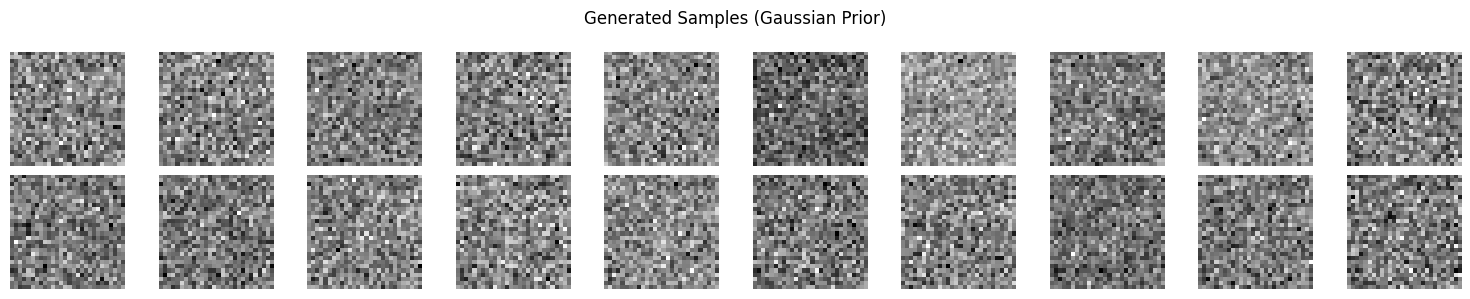

Gaussian generations saved as 'vae_gaussian_generations.png'

Generating samples from Laplacian prior...


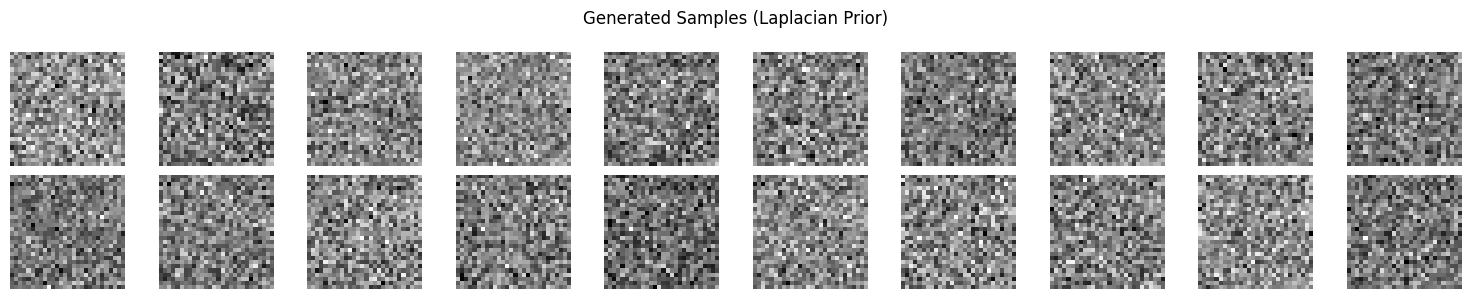

Laplacian generations saved as 'vae_laplacian_generations.png'

Generating comparison plot...


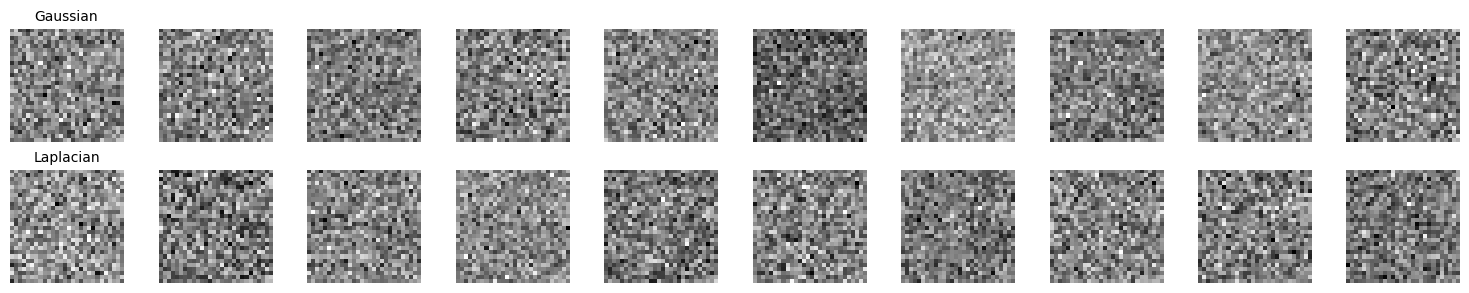

Comparison saved as 'vae_prior_comparison.png'

Calculating reconstruction metrics...
Reconstruction MSE: 0.1781

All visualizations complete


In [7]:
#loading vae model
vae_model = VAE().to(device)
optimiser = optim.Adam(vae_model.parameters(), lr=1e-3)

#loading test dataset
transformed = transforms.ToTensor()
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transformed)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

#getting test samples
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)

#setting model to evaluation mode
vae_model.eval()

#part a: visualizing reconstructions
print("Generating reconstructions...")

with torch.no_grad():
  reconstructed, mu, logvar = vae_model(test_images)
  reconstructed = reconstructed.view(-1, 1, 28, 28)

#plotting original vs reconstructed
fig, axes = plt.subplots(2, 10, figsize=(15, 3))

for i in range(10):
  #original images
  axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
  axes[0, i].axis('off')
  if i == 0:
    axes[0, i].set_title('Original', fontsize=10)

  #reconstructed images
  axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
  axes[1, i].axis('off')
  if i == 0:
    axes[1, i].set_title('Reconstructed', fontsize=10)

plt.tight_layout()
plt.savefig('vae_reconstructions.png')
plt.show()

print("Reconstructions saved as 'vae_reconstructions.png'")

#part b: generating samples from gaussian prior
print("\nGenerating samples from Gaussian prior...")

num_samples = 20
latent_dim = 20

#sampling from standard normal distribution
with torch.no_grad():
  z_gaussian = torch.randn(num_samples, latent_dim).to(device)
  generated_gaussian = vae_model.decode(z_gaussian)
  generated_gaussian = generated_gaussian.view(-1, 1, 28, 28)

#plotting generated samples
fig, axes = plt.subplots(2, 10, figsize=(15, 3))

for i in range(20):
  row = i // 10
  col = i % 10
  axes[row, col].imshow(generated_gaussian[i].cpu().squeeze(), cmap='gray')
  axes[row, col].axis('off')

plt.suptitle('Generated Samples (Gaussian Prior)', fontsize=12)
plt.tight_layout()
plt.savefig('vae_gaussian_generations.png')
plt.show()

print("Gaussian generations saved as 'vae_gaussian_generations.png'")

#part c: generating samples from laplacian prior
print("\nGenerating samples from Laplacian prior...")

#sampling from laplacian distribution
with torch.no_grad():
  #laplacian distribution: mean=0, scale=1
  z_laplacian = torch.distributions.Laplace(0, 1).sample((num_samples, latent_dim)).to(device)
  generated_laplacian = vae_model.decode(z_laplacian)
  generated_laplacian = generated_laplacian.view(-1, 1, 28, 28)

#plotting laplacian generated samples
fig, axes = plt.subplots(2, 10, figsize=(15, 3))

for i in range(20):
  row = i // 10
  col = i % 10
  axes[row, col].imshow(generated_laplacian[i].cpu().squeeze(), cmap='gray')
  axes[row, col].axis('off')

plt.suptitle('Generated Samples (Laplacian Prior)', fontsize=12)
plt.tight_layout()
plt.savefig('vae_laplacian_generations.png')
plt.show()

print("Laplacian generations saved as 'vae_laplacian_generations.png'")

#part d: side by side comparison of priors
print("\nGenerating comparison plot...")

fig, axes = plt.subplots(2, 10, figsize=(15, 3))

#top row: gaussian
for i in range(10):
  axes[0, i].imshow(generated_gaussian[i].cpu().squeeze(), cmap='gray')
  axes[0, i].axis('off')
  if i == 0:
    axes[0, i].set_title('Gaussian', fontsize=10)

#bottom row: laplacian
for i in range(10):
  axes[1, i].imshow(generated_laplacian[i].cpu().squeeze(), cmap='gray')
  axes[1, i].axis('off')
  if i == 0:
    axes[1, i].set_title('Laplacian', fontsize=10)

plt.tight_layout()
plt.savefig('vae_prior_comparison.png')
plt.show()

print("Comparison saved as 'vae_prior_comparison.png'")

#calculating reconstruction quality metrics
print("\nCalculating reconstruction metrics...")

with torch.no_grad():
  reconstructed_test, _, _ = vae_model(test_images)
  mse = F.mse_loss(reconstructed_test, test_images.view(-1, 784))
  print(f"Reconstruction MSE: {mse.item():.4f}")

print("\nAll visualizations complete")

Part 3

100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.79MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 60.8MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.2MB/s]


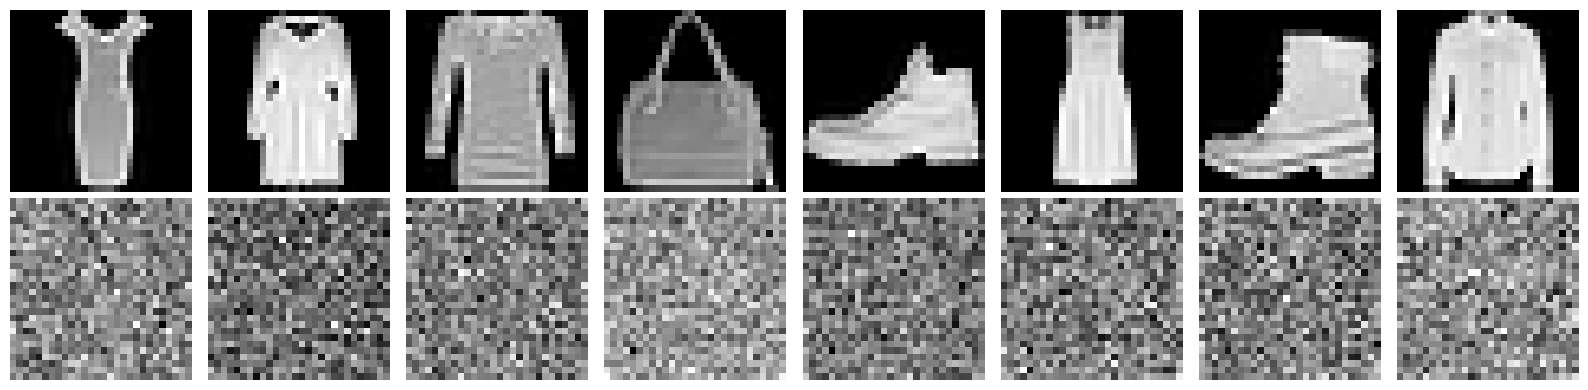

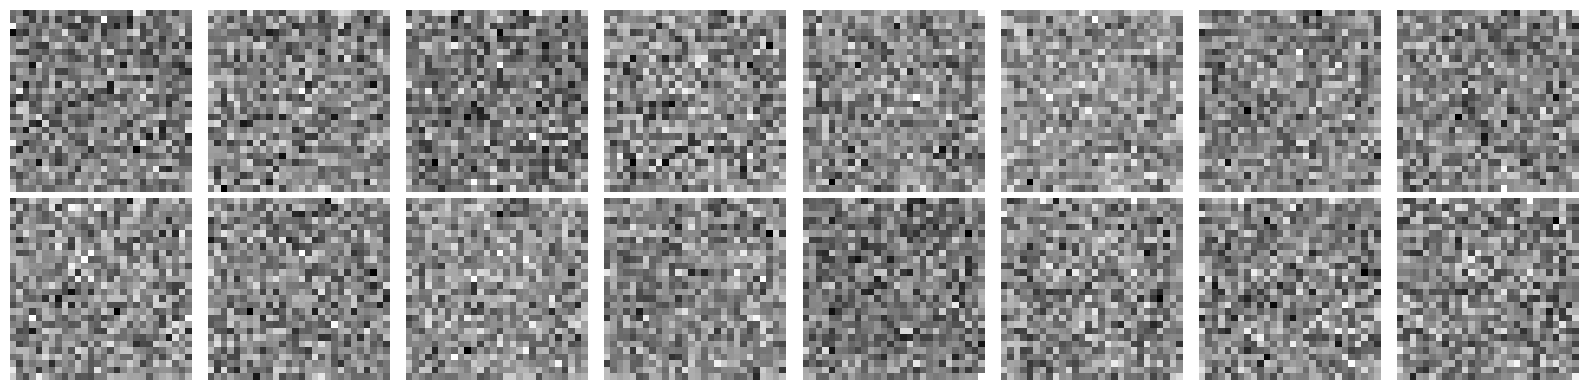

Reconstruction Loss: 135.3499
KL Divergence: 0.1683
Ratio: 804.2945


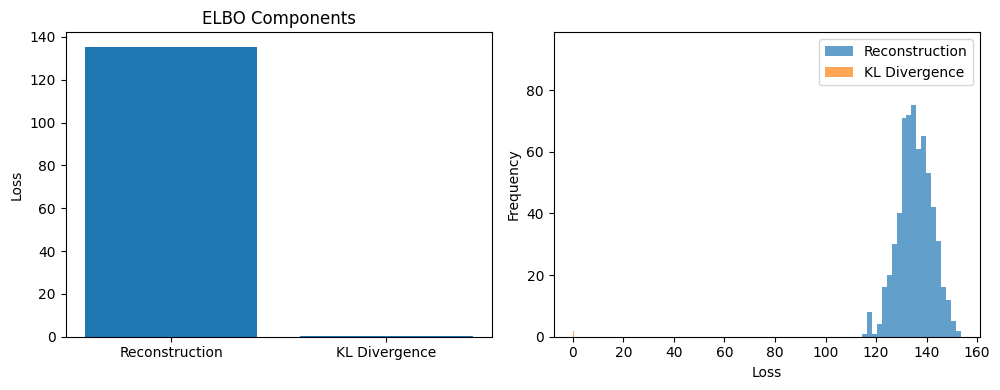


Mean of latent means: 0.0095
Std of latent means: 0.0811
Mean of latent stds: 1.0161


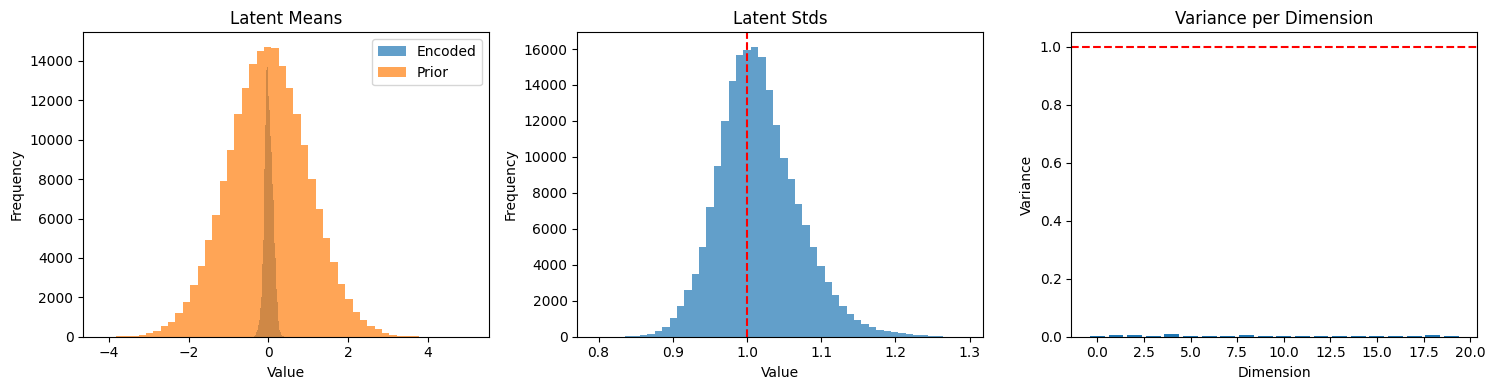


Inactive dimensions: 20/20
Low KL - posterior collapse likely
Many inactive dimensions - collapse detected


In [4]:
#loading vae model
vae_model = VAE().to(device)
optimiser = optim.Adam(vae_model.parameters(), lr=1e-3)

#loading test dataset
transformed = transforms.ToTensor()
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transformed)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

#getting test samples
test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device)

vae_model.eval()

#generating reconstructions
with torch.no_grad():
  reconstructed, mu, logvar = vae_model(test_images)
  reconstructed = reconstructed.view(-1, 1, 28, 28)

#plotting reconstructions
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
  axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
  axes[0, i].axis('off')

  axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
  axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('reconstructions.png')
plt.show()

#generating samples
num_samples = 16
latent_dim = 20

with torch.no_grad():
  z_samples = torch.randn(num_samples, latent_dim).to(device)
  generated = vae_model.decode(z_samples)
  generated = generated.view(-1, 1, 28, 28)

#plotting generated samples
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i in range(16):
  row = i // 8
  col = i % 8
  axes[row, col].imshow(generated[i].cpu().squeeze(), cmap='gray')
  axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('generations.png')
plt.show()

#analyzing elbo components
reconstruction_losses = []
kl_divergences = []

with torch.no_grad():
  for inputs, _ in test_loader:
    inputs = inputs.to(device)
    reconstructed, mu, logvar = vae_model(inputs)

    recon_loss = F.mse_loss(reconstructed, inputs.view(-1, 784), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    reconstruction_losses.append(recon_loss.item() / inputs.size(0))
    kl_divergences.append(kl_div.item() / inputs.size(0))

avg_recon_loss = np.mean(reconstruction_losses)
avg_kl_div = np.mean(kl_divergences)

print(f"Reconstruction Loss: {avg_recon_loss:.4f}")
print(f"KL Divergence: {avg_kl_div:.4f}")
print(f"Ratio: {avg_recon_loss/avg_kl_div:.4f}")

#plotting loss components
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(['Reconstruction', 'KL Divergence'], [avg_recon_loss, avg_kl_div])
plt.ylabel('Loss')
plt.title('ELBO Components')

plt.subplot(1, 2, 2)
plt.hist(reconstruction_losses, bins=20, alpha=0.7, label='Reconstruction')
plt.hist(kl_divergences, bins=20, alpha=0.7, label='KL Divergence')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.savefig('elbo_components.png')
plt.show()

#checking for posterior collapse
latent_means = []
latent_stds = []

with torch.no_grad():
  for inputs, _ in test_loader:
    inputs = inputs.to(device)
    _, mu, logvar = vae_model(inputs)

    latent_means.append(mu.cpu().numpy())
    latent_stds.append(torch.exp(0.5 * logvar).cpu().numpy())

latent_means = np.concatenate(latent_means, axis=0)
latent_stds = np.concatenate(latent_stds, axis=0)

mean_of_means = latent_means.mean(axis=0)
mean_of_stds = latent_stds.mean(axis=0)

print(f"\nMean of latent means: {mean_of_means.mean():.4f}")
print(f"Std of latent means: {mean_of_means.std():.4f}")
print(f"Mean of latent stds: {mean_of_stds.mean():.4f}")

#plotting distribution comparison
prior_samples = np.random.randn(latent_means.shape[0], latent_means.shape[1])
dim_variances = latent_means.var(axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(latent_means.flatten(), bins=50, alpha=0.7, label='Encoded')
axes[0].hist(prior_samples.flatten(), bins=50, alpha=0.7, label='Prior')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Latent Means')
axes[0].legend()

axes[1].hist(latent_stds.flatten(), bins=50, alpha=0.7)
axes[1].axvline(x=1.0, color='r', linestyle='--')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Latent Stds')

axes[2].bar(range(latent_dim), dim_variances)
axes[2].axhline(y=1.0, color='r', linestyle='--')
axes[2].set_xlabel('Dimension')
axes[2].set_ylabel('Variance')
axes[2].set_title('Variance per Dimension')

plt.tight_layout()
plt.savefig('posterior_analysis.png')
plt.show()

#collapse detection
num_inactive = np.sum(dim_variances < 0.01)
print(f"\nInactive dimensions: {num_inactive}/{latent_dim}")

if avg_kl_div < 5.0:
  print("Low KL - posterior collapse likely")
if num_inactive > latent_dim // 2:
  print("Many inactive dimensions - collapse detected")

Part 4

In [6]:
#loss function with beta
def vae_loss_beta(reconstructed, original, mu, logvar, beta=1.0):
  recon_loss = F.mse_loss(reconstructed, original.view(-1, 784), reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return recon_loss + beta * kl_loss, recon_loss.item(), kl_loss.item()

#loading data
transformed = transforms.ToTensor()

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transformed)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transformed)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

#creating new model instance for improved training
vae_improved = VAE().to(device)
optimiser = optim.Adam(vae_improved.parameters(), lr=1e-3)

#training parameters
num_epochs = 15
warmup_epochs = 5

train_losses = []
val_losses = []
recon_history = []
kl_history = []
beta_history = []

print("Training with KL annealing")

for epoch in range(num_epochs):

  #calculating beta
  if epoch < warmup_epochs:
    beta = epoch / warmup_epochs
  else:
    beta = 1.0

  beta_history.append(beta)

  #training phase
  vae_improved.train()
  training_loss = 0
  epoch_recon = 0
  epoch_kl = 0

  for inputs, _ in train_loader:
    inputs = inputs.to(device)

    optimiser.zero_grad()
    reconstructed, mu, logvar = vae_improved(inputs)
    loss, recon, kl = vae_loss_beta(reconstructed, inputs, mu, logvar, beta=beta)
    loss.backward()
    optimiser.step()

    training_loss += loss.item()
    epoch_recon += recon
    epoch_kl += kl

  train_loss = training_loss / len(train_dataset)
  train_losses.append(train_loss)
  recon_history.append(epoch_recon / len(train_dataset))
  kl_history.append(epoch_kl / len(train_dataset))

  #validation phase
  vae_improved.eval()
  validation_loss = 0

  with torch.no_grad():
    for inputs, _ in val_loader:
      inputs = inputs.to(device)
      reconstructed, mu, logvar = vae_improved(inputs)
      loss, _, _ = vae_loss_beta(reconstructed, inputs, mu, logvar, beta=1.0)
      validation_loss += loss.item()

  val_loss = validation_loss / len(val_dataset)
  val_losses.append(val_loss)

  print(f"Epoch {epoch+1}/{num_epochs} (beta={beta:.2f}) - Train: {train_loss:.2f}, Val: {val_loss:.2f}")

print("Training complete")

# ... rest of the visualization code ...

Training with KL annealing
Epoch 1/15 (beta=0.00) - Train: 23.28, Val: 229.37
Epoch 2/15 (beta=0.20) - Train: 20.97, Val: 38.82
Epoch 3/15 (beta=0.40) - Train: 22.44, Val: 32.22
Epoch 4/15 (beta=0.60) - Train: 24.34, Val: 29.28
Epoch 5/15 (beta=0.80) - Train: 25.88, Val: 27.61
Epoch 6/15 (beta=1.00) - Train: 27.26, Val: 27.07
Epoch 7/15 (beta=1.00) - Train: 26.77, Val: 27.20
Epoch 8/15 (beta=1.00) - Train: 26.43, Val: 26.31
Epoch 9/15 (beta=1.00) - Train: 26.17, Val: 26.13
Epoch 10/15 (beta=1.00) - Train: 25.92, Val: 25.91
Epoch 11/15 (beta=1.00) - Train: 25.73, Val: 25.71
Epoch 12/15 (beta=1.00) - Train: 25.53, Val: 25.52
Epoch 13/15 (beta=1.00) - Train: 25.40, Val: 25.34
Epoch 14/15 (beta=1.00) - Train: 25.23, Val: 25.22
Epoch 15/15 (beta=1.00) - Train: 25.13, Val: 25.08
Training complete
